In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from functools import partial
import talib
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm, kurtosis, skew
from scipy.stats import norm

In [615]:


#data = pd.read_csv('/Users/guneykan/Downloads/48_Industry_Portfolios.CSV', index_col=0)
data_daily = pd.read_csv('/Users/guneykan/Downloads/48_Industry_Portfolios_daily.CSV', index_col=0)
data_monthly = pd.read_csv('/Users/guneykan/Downloads/48_Industry_Portfolios.CSV', index_col=0)

data_daily = data_daily[('197401' <= data_daily.index.values.astype(str)) & (data_daily.index.values.astype(str) <= '201912')]
data_monthly = data_monthly[('197401' <= data_monthly.index.values.astype(str)) & (data_monthly.index.values.astype(str) <= '201912')]


data_daily.index = pd.to_datetime(data_daily.index, format="%Y%m%d")
data_monthly.index = pd.to_datetime(data_monthly.index, format="%Y%m")

date_daily = data_daily.index.date
date_monthly = data_monthly.index.date

# The rate of return matrix, fill missing values with 100%
R = data_daily.values.T.astype(np.float)
R[R < -99]
R = (R + 100) / 100  # Gross Return

In [753]:
data_daily.head()

Agric  Food   Soda   Beer   Smoke  Toys   Fun    Books  Hshld  \
1974-01-02  -0.61   0.20  -0.82  -0.60   0.76   0.28  -1.86   0.95  -0.20   
1974-01-03   3.79   2.64   2.09   2.22   2.97   4.61   0.64   1.40   0.73   
1974-01-04   0.46   0.55  -1.27  -0.65  -0.24  -0.45  -2.58  -0.38  -2.39   
1974-01-07  -1.55   0.01  -1.18  -1.37  -0.81  -1.06   3.15  -0.28  -1.78   
1974-01-08  -1.31  -1.20  -2.41  -2.53  -2.30  -2.73  -4.72  -0.96  -2.20   

            Clths  ...  Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  \
1974-01-02   1.43  ...   1.15   1.04   2.43  -0.13   1.42  -0.66   0.22   
1974-01-03   4.42  ...   1.14   2.52   3.70   2.48   1.04   1.33   2.69   
1974-01-04   1.50  ...  -0.65  -0.50   0.86   0.77  -3.98   0.13   0.10   
1974-01-07  -0.09  ...  -2.01  -2.61   0.49  -0.48  -2.82   0.46  -0.15   
1974-01-08  -0.44  ...  -1.58  -3.01  -2.12  -1.97  -2.57  -1.65  -0.16   

            RlEst  Fin    Other  
1974-01-02   1.97   0.82   0.12  
1974-01-03   4.22   2.60   1.72  
1974-01-04   1.25  -0.12  -0.29  
1974-01-07   1.76   0.01   0.15  
1974-01-08  -1.35  -0.75  -1.05  

[5 rows x 48 columns]

# Daily

In [616]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

class BanditPortfolio:
    def __init__(self, R):
        self.R = R
        self.n_arms, self.n_samples = R.shape
        
    def UCB(self, window_size):
        self.reward = np.ones(self.n_samples - window_size)
        self.played_times = np.ones(self.n_arms)
        
        for t in range(window_size, self.n_samples):
            sliceR = self.R[:, t-window_size:t]
            
            # Compute the covariance matrix
            covariance_matrix =  np.cov(sliceR)
            
            # Eigenvalue Decomposition
            A, H = np.linalg.eig(covariance_matrix)
            
            # All eigenvalues are positive
            assert(np.sum(A<0) == 0)
            
            # Sort the eigenvalues
            idx = np.argsort(-A)
            A = np.diag(A[idx])
            H = H[:,idx]
            l = np.argwhere(np.median(np.diag(A)) > np.diag(A))[0][0]
            
            # Normalized weight
            H /= np.sum(H, axis= 0)
            ANew =  H.T.dot(covariance_matrix).dot(H)
            
            # Compute the sharpe ratio
            portfolio_reward = H.T.dot(sliceR)

            sharpe_ratio = np.mean(portfolio_reward, axis=1) / np.sqrt(ANew.diagonal())
            #sharpe_ratio = MinMaxScaler().fit_transform(sharpe_ratio.reshape(-1,1)).reshape(-1)
            
            # Compute the upper bound of expected reward
            sharpe_ratio_upper_bound = sharpe_ratio + np.sqrt((2*np.log(t))/(window_size+self.played_times))
            
            # Select the optimal arm
            action1 = np.argmax(sharpe_ratio_upper_bound[:l])
            action2 = np.argmax(sharpe_ratio_upper_bound[l:])+l

            self.played_times[action1] += 1
            self.played_times[action2] += 1

            # Optimal weight
            Adiag = ANew.diagonal()
            theta = Adiag[action1] / (Adiag[action1] + Adiag[action2])
            self.weight = (1-theta)*H[:,action1] + theta*H[:,action2]
            
            self.reward[t-window_size] = self.weight.dot(self.R[:,t])
            
    def TS(self, window_size):
        self.reward = np.ones(self.n_samples - window_size)
        self.mv_reward = np.ones(self.n_samples - window_size)
        self.played_times = np.ones(self.n_arms)
        self.success = np.ones(4)
        self.fail = np.ones(4)

        for t in range(window_size, self.n_samples):

            sliceR = self.R[:, t-window_size:t]

            # Compute the covariance matrix
            covariance_matrix = np.cov(sliceR)  # histroical covariance

            # Eigenvalue Decomposition
            A, H = np.linalg.eig(covariance_matrix)  # equation 5

            # All eigenvalues are positive
            assert(np.sum(A < 0) == 0)

            # Sort the eigenvalues
            idx = np.argsort(-A)  # sort eigenvalues
            A = np.diag(A[idx])  #  eigenvalues as vector
            H = H[:, idx]  #  n(number of assets) orthonormal portfolios
            l = np.argwhere(np.median(np.diag(A)) > np.diag(A))[0][0]

            # Normalized weight
            H /= np.sum(H, axis=0)  # equation 7 normalized eigenvectors
            #  equation 8 normalized eigenvalues matrix
            ANew = H.T.dot(covariance_matrix).dot(H)

            # Compute the sharpe ratio
            #  Return of each port. in the slice window
            portfolio_reward = H.T.dot(sliceR)
            # Estimator of portfolio return, rolling average
            sharpe_ratio = np.mean(
                portfolio_reward, axis=1) / np.sqrt(ANew.diagonal())
            # Normalize the sharpe ratio
            #sharpe_ratio = MinMaxScaler().fit_transform(
            #    sharpe_ratio.reshape(-1, 1)).reshape(-1)

            # Compute the upper bound of expected reward
            sharpe_ratio_upper_bound = sharpe_ratio + \
                np.sqrt((2*np.log(t))/(window_size+self.played_times))

            # Select the optimal arm
            #  passive portfolios
            action1 = np.argmax(sharpe_ratio_upper_bound[:l])
            #  active portfolios
            action2 = np.argmax(sharpe_ratio_upper_bound[l:])+l

            #  update the times portfolio played
            self.played_times[action1] += 1
            self.played_times[action2] += 1  # update the second action

            # Optimal weight, Min var allocation between 2 chosen portfolios
            Adiag = ANew.diagonal()
            theta = Adiag[action1] / (Adiag[action1] + Adiag[action2])
            
            self.psr_set = []
            #psr_second_set = []
            for a in range(len(sharpe_ratio)):
                sr = sharpe_ratio[a]
                n = (window_size+self.played_times[a])/window_size
                skewness = skew(portfolio_reward[a, :])
                kurto = kurtosis(portfolio_reward[a, :])
                nomin = (sr-np.mean(sharpe_ratio))*np.sqrt(n)
                denom = np.sqrt(np.abs((1 + 0.5*sr**2 - skewness*sr + ((kurto-3)/4)*sr**2))/(n-1))
                self.psr_set.append(nomin/denom)
                
                
            self.psr_set = np.array([norm.cdf(a) for a in self.psr_set])
            
            sharpe_ratio_upper_bound_psr = (sharpe_ratio + \
                np.sqrt((2*np.log(t))/(window_size+self.played_times)))*np.array(self.psr_set)
                
            
            action_1_1 = np.argmax(sharpe_ratio_upper_bound_psr[:l])
            action_1_2 = np.argmax(sharpe_ratio_upper_bound_psr[l:])+l


            # Optimal weight
            theta_ = Adiag[action_1_1] / (Adiag[action_1_1] + Adiag[action_1_2])
                        
            
            
            self.weight_1 = (1-theta)*H[:, action1] + theta*H[:, action2]
            
            self.weight_2 = np.ones(self.n_arms)/self.n_arms
            
            self.weight_3 = (np.linalg.inv(covariance_matrix)@np.ones(self.n_arms).reshape(-1, 1))/(np.ones(
                self.n_arms).reshape(-1, 1).T@np.linalg.inv(covariance_matrix)@np.ones(self.n_arms).reshape(-1, 1))
            
            self.weight_4 = (1-theta_)*H[:,action_1_1] + theta_*H[:,action_1_2]
            
            
            final_actions = [self.weight_1, self.weight_2, self.weight_3, self.weight_4]
            draws = [np.random.beta(self.success[action], self.fail[action])
                     for action in range(4)]
            
            final_weight = final_actions[np.argmax(draws)]
            
            self.reward[t-window_size] = final_weight.T.dot(self.R[:, t])
            self.mv_reward[t-window_size] = self.weight_3.T.dot(self.R[:, t])
            
            rewards = [self.weight_1.T.dot(self.R[:, t]), self.weight_2.T.dot(self.R[:, t]), self.weight_3.T.dot(self.R[:, t]), self.weight_4.T.dot(self.R[:, t])]
            
            

            if np.max(rewards) == final_weight.T@self.R[:, t]:
                self.success[np.argmax(draws)] += 1
                other_idx = [a for a in range(4) if a != np.argmax(rewards)]
                self.fail[other_idx[0]] +=1
                self.fail[other_idx[1]] +=1
                self.fail[other_idx[2]] +=1
            else:
                other_idx = [a for a in range(4) if (a != np.argmax(rewards)) & (a != np.argmax(draws))]
                self.success[np.argmax(rewards)] +=1
                self.fail[other_idx[0]] +=1
                self.fail[other_idx[1]] +=1
                self.fail[np.argmax(draws)] += 1
                
    def UCBPSR(self, window_size):
        self.reward = np.ones(self.n_samples - window_size)
        self.played_times = np.ones(self.n_arms)
        self.psr = {}
        
        for t in range(window_size, self.n_samples):
            sliceR = self.R[:, t-window_size:t]
            
            # Compute the covariance matrix
            covariance_matrix =  np.cov(sliceR)
            
            # Eigenvalue Decomposition
            A, H = np.linalg.eig(covariance_matrix)
            
            # All eigenvalues are positive
            assert(np.sum(A<0) == 0)
            
            # Sort the eigenvalues
            idx = np.argsort(-A)
            A = np.diag(A[idx])
            H = H[:,idx]
            l = np.argwhere(np.median(np.diag(A)) > np.diag(A))[0][0]
            
            # Normalized weight
            H /= np.sum(H, axis= 0)
            ANew =  H.T.dot(covariance_matrix).dot(H)
            
            # Compute the sharpe ratio
            portfolio_reward = H.T.dot(sliceR)

            
            sharpe_ratio = (np.mean(portfolio_reward, axis=1) / np.sqrt(ANew.diagonal()))
            #sharpe_ratio = MinMaxScaler().fit_transform(sharpe_ratio.reshape(-1,1)).reshape(-1)
            #scl = MinMaxScaler()
            #sharpe_ratio = scl.fit_transform(sharpe_ratio.reshape(-1,1)).reshape(-1)
            
            
            
            self.psr_set = []
            for a in range(len(sharpe_ratio)):
                sr = sharpe_ratio[a]
                n = (window_size+self.played_times[a])/window_size
                skewness = skew(portfolio_reward[a, :])
                kurto = kurtosis(portfolio_reward[a, :])
                nomin = (sr-np.mean(sharpe_ratio))*np.sqrt(n)
                denom = np.sqrt(np.abs((1 + 0.5*sr**2 - skewness*sr + ((kurto-3)/4)*sr**2))/(n-1))
                #psr = norm.cdf(nomin/denom)
                self.psr_set.append(nomin/denom)
            #self.psr_set = scl.fit_transform(np.array(self.psr_set).reshape(-1,1)).reshape(-1)
            self.psr_set = np.array([norm.cdf(a) for a in self.psr_set])
            self.psr[t] = self.psr_set
            
            # Compute the upper bound of expected reward
            #sharpe_ratio_upper_bound = sharpe_ratio + np.sqrt((2*np.log(t))/(window_size+self.played_times))
            sharpe_ratio_upper_bound = (sharpe_ratio + \
                np.sqrt((2*np.log(t))/(window_size+self.played_times)))*np.array(self.psr_set)
            
            action1 = np.argmax(sharpe_ratio_upper_bound[:l])
            action2 = np.argmax(sharpe_ratio_upper_bound[l:])+l
            
            # Select the optimal arm
            #action1 = np.argmax(self.psr_set[:l])
            #action2 = np.argmax(self.psr_set[l:])+l

            self.played_times[action1] += 1
            self.played_times[action2] += 1

            # Optimal weight
            Adiag = ANew.diagonal()
            theta = Adiag[action1] / (Adiag[action1] + Adiag[action2])
            self.weight = (1-theta)*H[:,action1] + theta*H[:,action2]
            
            self.reward[t-window_size] = self.weight.dot(self.R[:,t])
    def PSR(self, window_size):
        self.reward = np.ones(self.n_samples - window_size)
        self.played_times = np.ones(self.n_arms)
        self.psr = {}
        
        for t in range(window_size, self.n_samples):
            sliceR = self.R[:, t-window_size:t]
            
            # Compute the covariance matrix
            covariance_matrix =  np.cov(sliceR)
            
            # Eigenvalue Decomposition
            A, H = np.linalg.eig(covariance_matrix)
            
            # All eigenvalues are positive
            assert(np.sum(A<0) == 0)
            
            # Sort the eigenvalues
            idx = np.argsort(-A)
            A = np.diag(A[idx])
            H = H[:,idx]
            l = np.argwhere(np.median(np.diag(A)) > np.diag(A))[0][0]
            
            # Normalized weight
            H /= np.sum(H, axis= 0)
            ANew =  H.T.dot(covariance_matrix).dot(H)
            
            # Compute the sharpe ratio
            portfolio_reward = H.T.dot(sliceR)

            
            sharpe_ratio = (np.mean(portfolio_reward, axis=1) / np.sqrt(ANew.diagonal()))
            scl = MinMaxScaler(feature_range=(-3,3))
            #sharpe_ratio = scl.fit_transform(sharpe_ratio.reshape(-1,1)).reshape(-1)
            
            self.psr_set = []
            #psr_second_set = []
            for a in range(len(sharpe_ratio)):
                sr = sharpe_ratio[a]
                n = (window_size+self.played_times[a])/window_size
                skewness = skew(portfolio_reward[a, :])
                kurto = kurtosis(portfolio_reward[a, :])
                nomin = (sr-np.mean(sharpe_ratio))*np.sqrt(n-1)
                denom = np.sqrt(np.abs(1-(skewness*sr) + ((kurto-1)/4)*(sr**2)))
                #psr = norm.cdf(nomin/denom)
                self.psr_set.append(nomin/denom)
                
            self.psr_set = np.array([norm.cdf(a) for a in self.psr_set])
            self.psr[t] = self.psr_set
            
            # Compute the upper bound of expected reward
            #sharpe_ratio_upper_bound = sharpe_ratio + np.sqrt((2*np.log(t))/(window_size+self.played_times))
            #sharpe_ratio_upper_bound = (sharpe_ratio + \
            #    np.sqrt((2*np.log(t))/(window_size+self.played_times)))*np.array(self.psr_set)
            
            #action1 = np.argmax(sharpe_ratio_upper_bound[:l])
            #action2 = np.argmax(sharpe_ratio_upper_bound[l:])+l
            
            # Select the optimal arm
            action1 = np.argmax(self.psr_set[:l])
            action2 = np.argmax(self.psr_set[l:])+l

            self.played_times[action1] += 1
            self.played_times[action2] += 1

            # Optimal weight
            Adiag = ANew.diagonal()
            theta = Adiag[action1] / (Adiag[action1] + Adiag[action2])
            self.weight = (1-theta)*H[:,action1] + theta*H[:,action2]
            
            self.reward[t-window_size] = self.weight.dot(self.R[:,t])

In [757]:
window_size = 120
orthogonal_bandit_portfolio = BanditPortfolio(R)

In [759]:
orthogonal_bandit_portfolio.UCB(window_size = window_size)
ucb_ret = orthogonal_bandit_portfolio.reward

In [760]:
orthogonal_bandit_portfolio.TS(window_size = window_size)
ts_ret = orthogonal_bandit_portfolio.reward
mv_ret = orthogonal_bandit_portfolio.mv_reward

In [761]:
orthogonal_bandit_portfolio.PSR(window_size = window_size)
psr_ret = orthogonal_bandit_portfolio.reward

In [762]:
orthogonal_bandit_portfolio.UCBPSR(window_size = window_size)
ucbpsr_ret = orthogonal_bandit_portfolio.reward

In [ ]:
#Baseline
constant_weight_rebalance = np.cumprod(R[:,window_size:].mean(axis=0))
equal_weight_portfolio = np.mean(np.cumprod(R[:,window_size:], axis=1), axis=0)b

date = data_daily.index.values[window_size:]

In [770]:
ew_ret = np.mean(R[:,window_size:], axis=0)

In [772]:
mv_ret.shape

(11462,)

In [773]:

all_rets = {"MVP": mv_ret, "EW": ew_ret, "UCB1": ucb_ret, "TS": ts_ret, "MaxPSR": psr_ret, "PW-UCB1": ucbpsr_ret} 

In [776]:
z = pd.DataFrame(all_rets)-1

In [779]:
z.to_csv("new_rets.csv")

In [623]:

all_wealth = {"MVP": mv_wealth, "CWR": constant_weight_rebalance, "EW": equal_weight_portfolio, "UCB1": ucb_wealth, "TS": ts_wealth, "MaxPSR": psr_wealth, "PW-UCB1": ucbpsr_wealth} 

In [624]:
results = pd.DataFrame(all_wealth)
results_pct = results.pct_change().dropna()

In [673]:
results_pct

MVP       CWR        EW      UCB1        TS    MaxPSR  \
1974-06-25 -0.001136  0.011338  0.011345 -0.002362 -0.002362 -0.015424   
1974-06-26  0.003636 -0.014506 -0.014531 -0.011187 -0.011187 -0.027692   
1974-06-27  0.003410 -0.016683 -0.016642 -0.007468 -0.007468 -0.002533   
1974-06-28  0.000720 -0.006581 -0.006559 -0.007853  0.000720 -0.009321   
1974-07-01 -0.000711 -0.003029 -0.002991 -0.003973 -0.000711 -0.003973   
...              ...       ...       ...       ...       ...       ...   
2019-11-22  0.006388  0.003721  0.002335 -0.001343  0.003721  0.009824   
2019-11-25  0.004378  0.010319  0.008470  0.010627  0.010319  0.021565   
2019-11-26 -0.003330  0.003252  0.002880 -0.009264 -0.009264 -0.000474   
2019-11-27  0.007049  0.003648  0.003884  0.005032  0.005032  0.005149   
2019-11-29 -0.004082 -0.005102 -0.004356 -0.005802 -0.005802 -0.004712   

             PW-UCB1  
1974-06-25  0.003756  
1974-06-26 -0.026456  
1974-06-27 -0.007468  
1974-06-28 -0.007853  
1974-07-01 -0.003973  
...              ...  
2019-11-22 -0.001343  
2019-11-25  0.010627  
2019-11-26 -0.009264  
2019-11-27  0.005032  
2019-11-29 -0.005966  

[11461 rows x 7 columns]

In [678]:
results_pct.std()*100*np.sqrt(252)

MVP        11.221622
CWR        16.174023
EW         15.809628
UCB1       17.830693
TS         16.900526
MaxPSR     21.836505
PW-UCB1    18.614563
dtype: float64

In [625]:
results.index = date

In [626]:
results_pct.index = date[1:]

In [627]:
years = pd.date_range(start="1974", end="2019", freq="y").year
years = [str(a) for a in years]

In [628]:
yearly_sharpes = {}

for col in results_pct.columns:
    col_ = {}
    for a in range(1, len(years)):
        col_[years[a]] = np.sqrt(252)*np.mean(results_pct.loc[years[a-1]:years[a], col])/np.std(results_pct.loc[years[a-1]:years[a], col])
    yearly_sharpes[col] = col_

In [629]:
yearly_sharpes = pd.DataFrame(yearly_sharpes)

In [668]:
results_pct.to_csv("pct_changes.csv")

In [630]:
yearly_sharpes.mean().sort_values(ascending=False)

PW-UCB1    1.095418
UCB1       1.071363
CWR        1.047409
EW         1.038473
MVP        0.992204
TS         0.964696
MaxPSR     0.736465
dtype: float64

In [631]:
((np.mean(results_pct)/np.std(results_pct))*np.sqrt(252)).sort_values(ascending=False)

PW-UCB1    0.919159
UCB1       0.914992
EW         0.814131
TS         0.809124
CWR        0.807491
MVP        0.754372
MaxPSR     0.546348
dtype: float64

In [648]:
results.loc["1984":"1994", :]

1984-01-03    3.132632
1984-01-04    3.185615
1984-01-05    3.182949
1984-01-06    3.163519
1984-01-09    3.161793
                ...   
1994-12-23    6.727101
1994-12-27    6.751909
1994-12-28    6.753042
1994-12-29    6.765401
1994-12-30    6.798588
Name: MVP, Length: 2781, dtype: float64

In [756]:
results.to_csv("results.csv")

In [744]:
wealth_74_84 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(
    7).reshape(-1, 7), results_pct.loc["1974":"1984", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1974":"1984", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1974":"1984", :].index[-1], periods=results_pct.loc["1974":"1984", :].shape[0]+1).date))

wealth_84_94 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(
    7).reshape(-1, 7), results_pct.loc["1984":"1994", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1984":"1994", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1984":"1994", :].index[-1], periods=results_pct.loc["1984":"1994", :].shape[0]+1).date))

wealth_94_04 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(
    7).reshape(-1, 7), results_pct.loc["1994":"2004", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1994":"2004", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1994":"2004", :].index[-1], periods=results_pct.loc["1994":"2004", :].shape[0]+1).date))

wealth_04_14 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(
    7).reshape(-1, 7), results_pct.loc["2004":"2014", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["2004":"2014", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["2004":"2014", :].index[-1], periods=results_pct.loc["2004":"2014", :].shape[0]+1).date))

wealth_14_20 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(
    7).reshape(-1, 7), results_pct.loc["2014":"2020", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["2014":"2020", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["2014":"2020", :].index[-1], periods=results_pct.loc["2014":"2020", :].shape[0]+1).date))

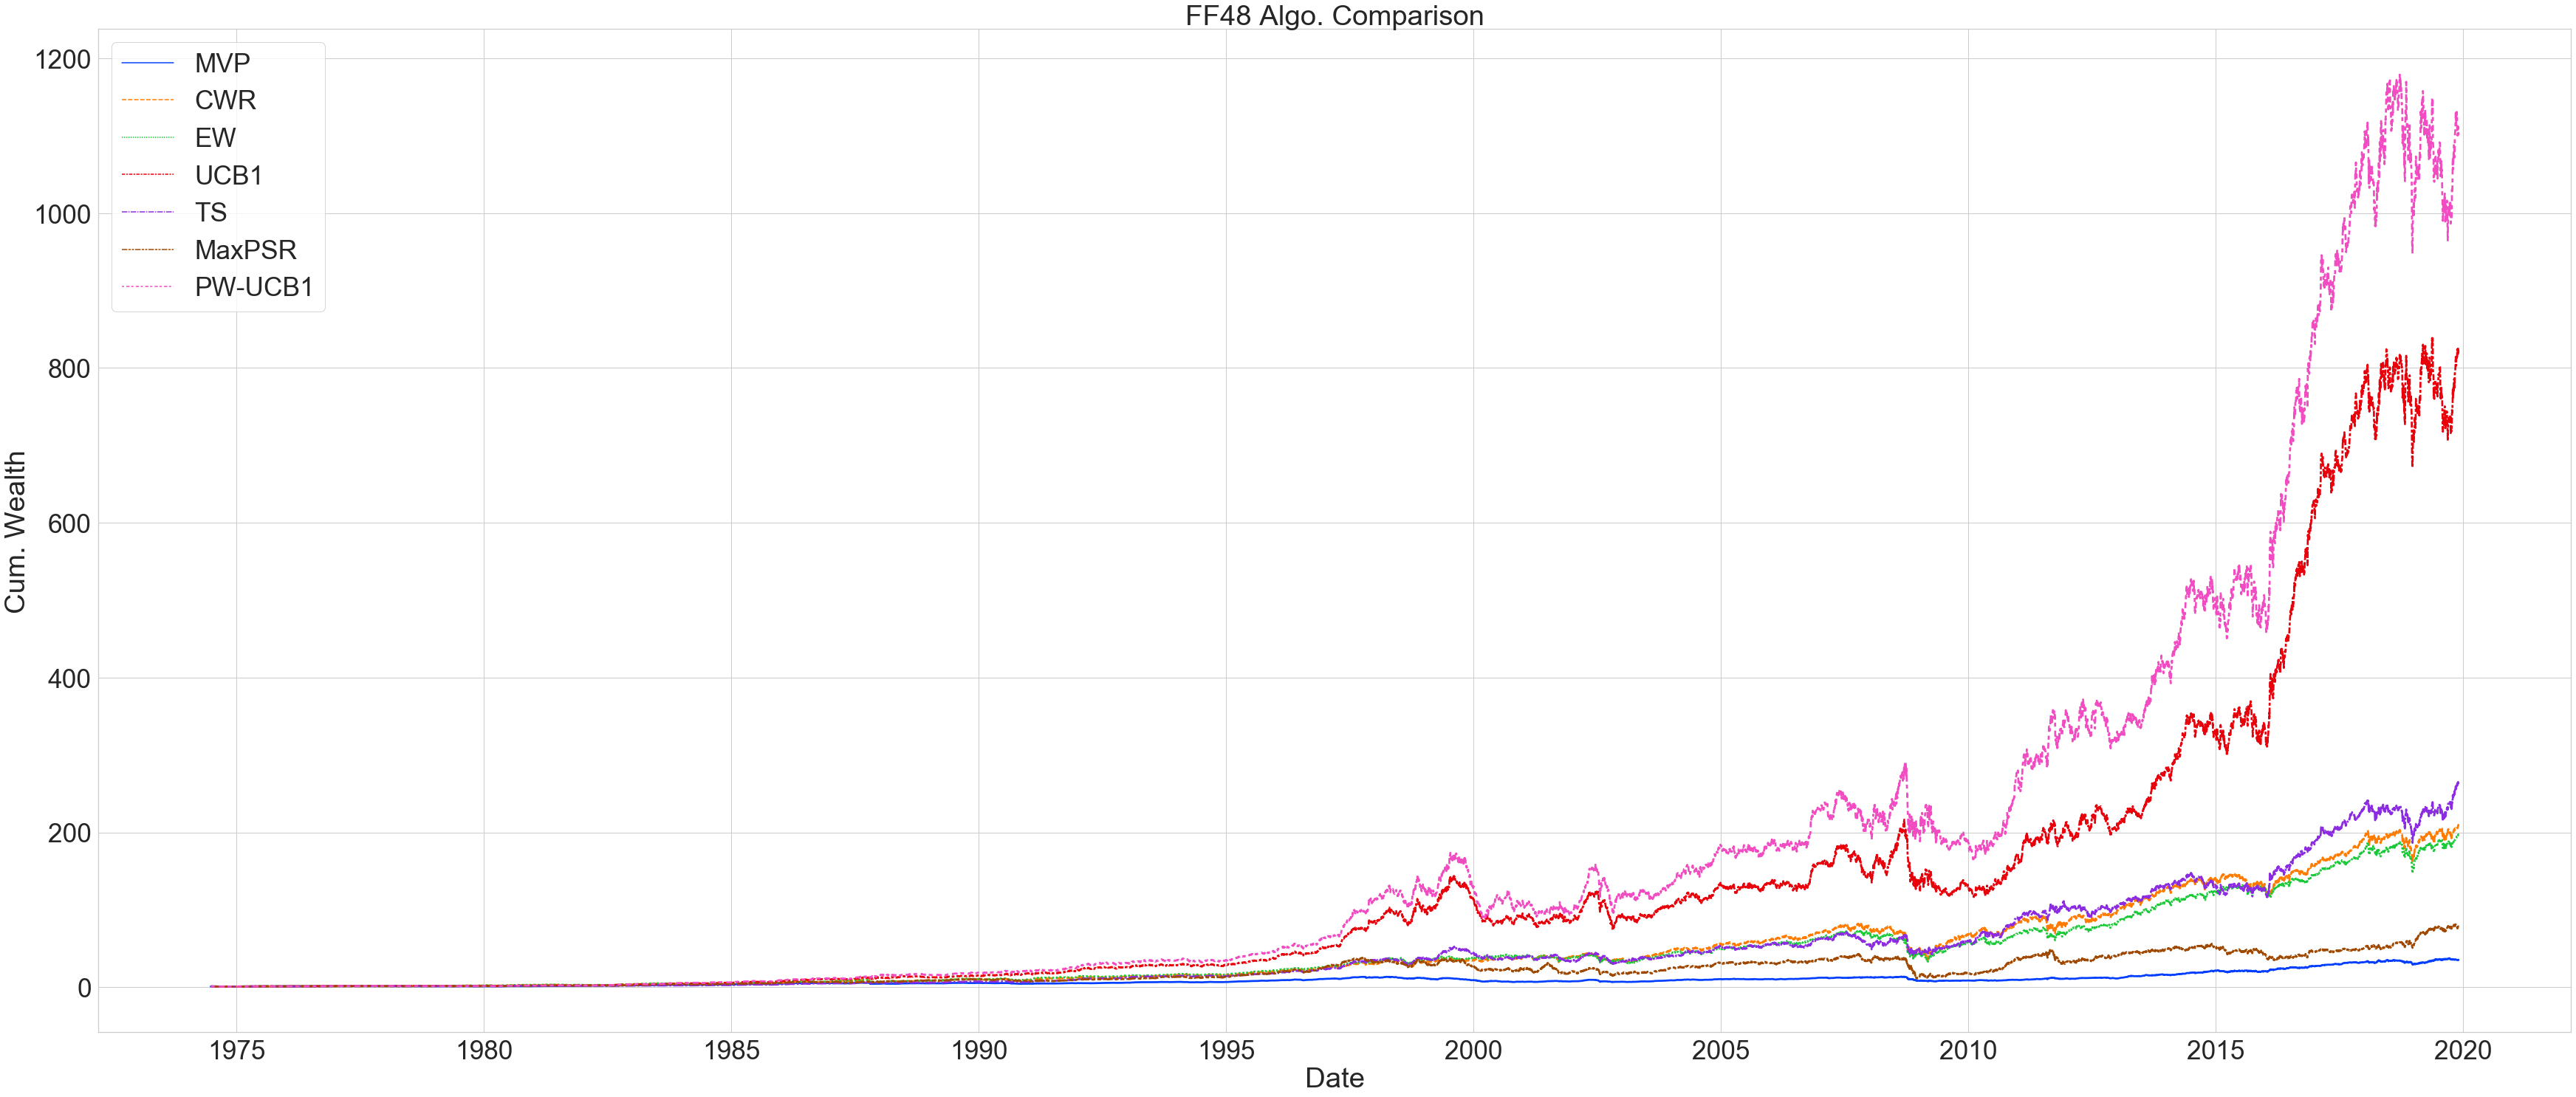

In [692]:
sns.set(style="whitegrid", font_scale=3.2)
plt.figure(figsize=(60, 25))
ax = sns.lineplot(data=results, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(xlabel="Date", ylabel='Cum. Wealth', title="FF48 Algo. Comparison");
ax.figure.savefig("output.png")

In [ ]:
import seaborn as sns

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]



sns.set(style="whitegrid", font_scale=3.3)
plt.figure(figsize=(60, 100))

plt.subplot(5,1,1)
ax = sns.lineplot(data=wealth_74_84, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth', title="FF48 Algo. Comparison")

plt.subplot(5,1,2)
ax = sns.lineplot(data=wealth_84_94, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

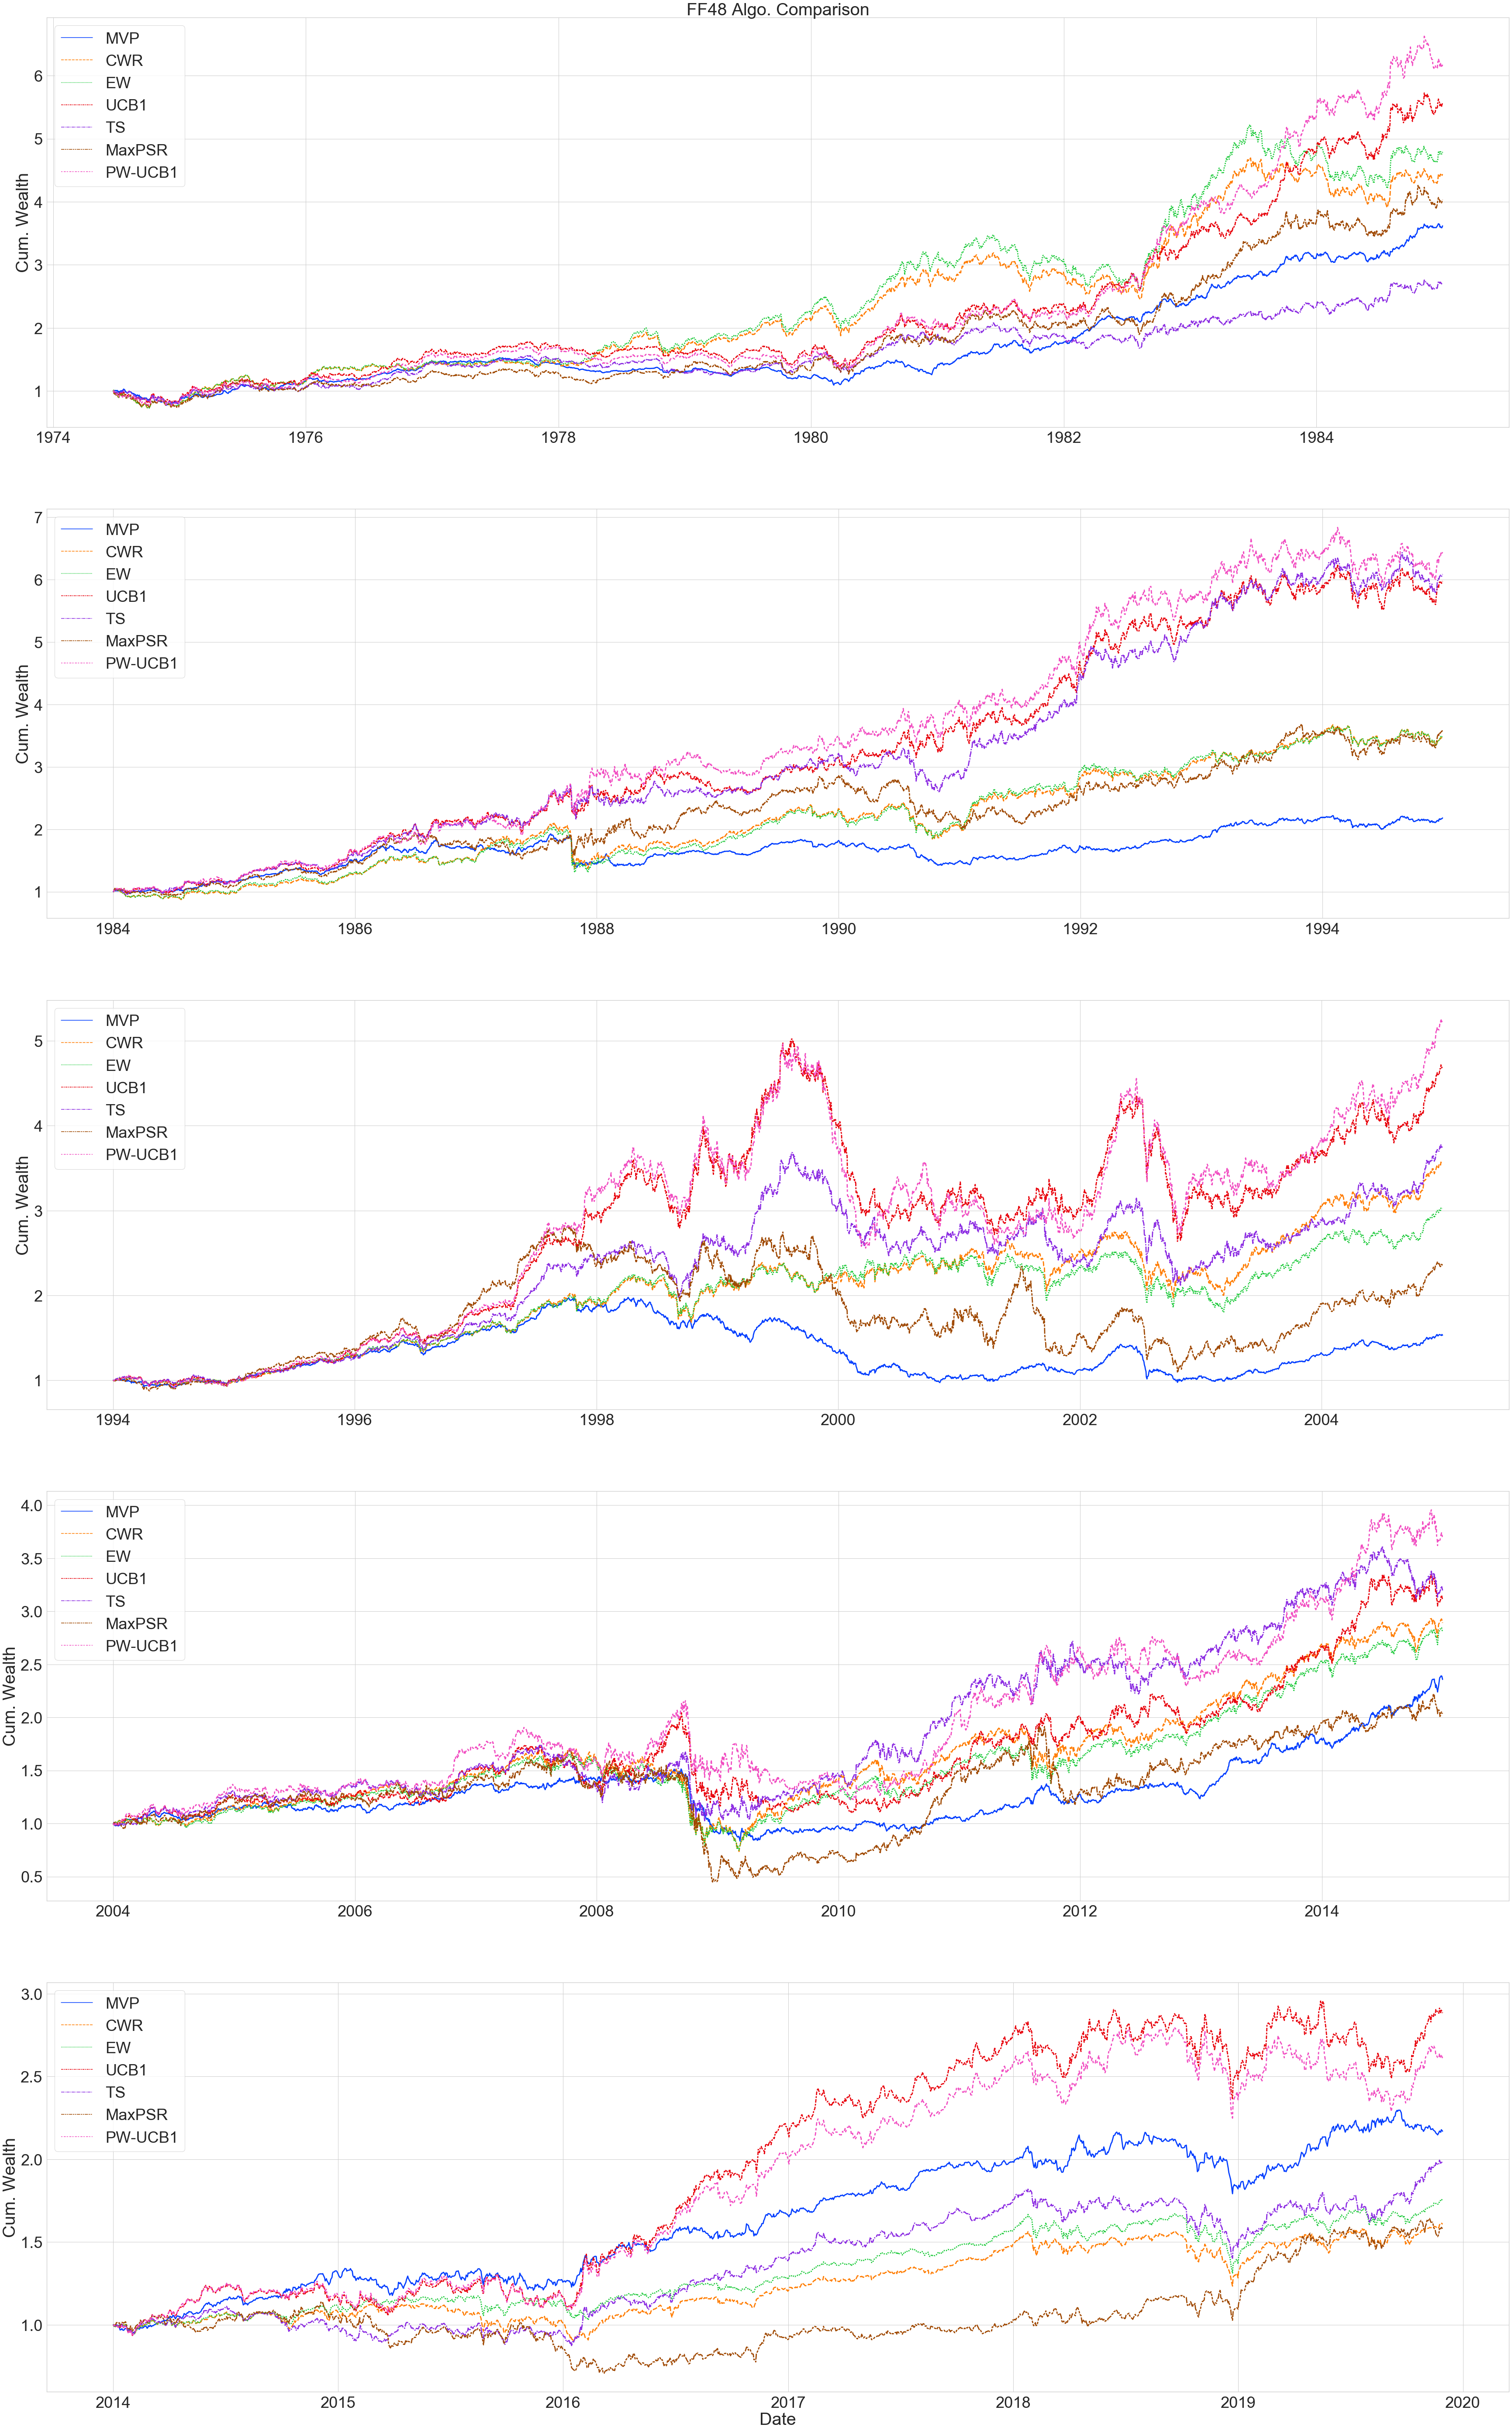

In [747]:
import seaborn as sns

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]



sns.set(style="whitegrid", font_scale=3.3)
plt.figure(figsize=(60, 100))

plt.subplot(5,1,1)
ax = sns.lineplot(data=wealth_74_84, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth', title="FF48 Algo. Comparison")

plt.subplot(5,1,2)
ax = sns.lineplot(data=wealth_84_94, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,3)
ax = sns.lineplot(data=wealth_94_04, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,4)
ax = sns.lineplot(data=wealth_04_14, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,5)
ax = sns.lineplot(data=wealth_14_20, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(xlabel="Date", ylabel='Cum. Wealth')
ax.figure.savefig("output_2.png")

In [749]:
yearly_sharpes.to_csv("year_sharpes.csv")

# 10-Portfolios - Daily


In [539]:

data_10 = pd.read_csv('/Users/guneykan/Downloads/48_Industry_Portfolios.CSV', index_col=0)

data_10 = data_10[('197401' <= data_10.index.values.astype(str)) & (data_10.index.values.astype(str) <= '201912')]

data_10.index = pd.to_datetime(data_10.index, format="%Y%m")

date_10 = data_10.index.date

# The rate of return matrix, fill missing values with 100%
R_10 = data_10.values.T.astype(np.float)
R_10[R_10 < -99]
R_10 = (R_10 + 100) / 100  # Gross Return

In [570]:
window_size = 120
orthogonal_bandit_portfolio_10 = BanditPortfolio(R_10)

In [571]:
orthogonal_bandit_portfolio_10.UCB(window_size = window_size)
ucb_10_wealth = np.cumprod(orthogonal_bandit_portfolio_10.reward)

In [572]:
orthogonal_bandit_portfolio_10.UCBPSR(window_size = window_size)
ucbpsr_10_wealth = np.cumprod(orthogonal_bandit_portfolio_10.reward)

In [573]:
orthogonal_bandit_portfolio_10.TS(window_size = window_size)
ts_10_wealth = np.cumprod(orthogonal_bandit_portfolio_10.reward)
mv_10_wealth = np.cumprod(orthogonal_bandit_portfolio_10.mv_reward)


In [574]:
orthogonal_bandit_portfolio_10.PSR(window_size = window_size)
psr_10_wealth = np.cumprod(orthogonal_bandit_portfolio_10.reward)


In [575]:
cw_10_wealth = np.cumprod(R_10[:,window_size:].mean(axis=0))
ew_10_wealth = np.mean(np.cumprod(R_10[:,window_size:], axis=1), axis=0)

In [576]:
all_10_wealth = {"MVP": mv_10_wealth, "CWR": cw_10_wealth, "EW": ew_10_wealth, "UCB1": ucb_10_wealth, "TS": ts_10_wealth, "MaxPSR": psr_10_wealth, "PW-UCB1": ucbpsr_10_wealth}

results_10 = pd.DataFrame(all_10_wealth)
results_pct_10 = results_10.pct_change().dropna()

In [577]:
results_10

MVP        CWR         EW       UCB1         TS    MaxPSR  \
0     0.972350   0.928244   0.928244   0.905598   0.905598  0.905598   
1     1.040083   0.983851   0.984385   0.991520   0.968681  0.967590   
2     0.982620   0.913287   0.914630   1.005095   0.915163  0.868264   
3     0.964984   0.958218   0.958273   0.984423   0.896341  0.888673   
4     0.964779   0.971412   0.972030   0.962004   0.896150  0.869082   
..         ...        ...        ...        ...        ...       ...   
397  12.961972  27.493954  23.893448  38.452117  26.044222  6.156221   
398  13.181731  27.990735  24.310754  40.996832  27.767797  6.454120   
399  12.673808  28.392286  24.648563  40.107761  27.165615  6.961684   
400  12.584826  29.254820  25.565882  41.443091  27.990884  7.002887   
401  13.447201  30.143435  26.202018  42.095945  28.431825  7.104574   

       PW-UCB1  
0     0.905598  
1     0.991520  
2     1.005095  
3     0.984423  
4     0.962004  
..         ...  
397  15.366434  
398  16.800655  
399  16.925716  
400  17.025893  
401  18.530416  

[402 rows x 7 columns]

In [578]:
results_pct_10.index = date_10[window_size+1:]

In [523]:
years = pd.date_range(start="1974", end="2019", freq="y").year
years = [str(a) for a in years]

results_pct_10.index = pd.to_datetime(results_pct_10.index)


In [524]:
yearly_sharpes = {}

for col in results_pct_10.columns:
    col_ = {}
    for a in range(1, len(years)):
        col_[years[a]] = np.sqrt(12)*np.mean(results_pct_10.loc[years[a-1]:years[a], col])/np.std(results_pct_10.loc[years[a-1]:years[a], col])
    yearly_sharpes[col] = col_

In [525]:
yearly_sharpes = pd.DataFrame(yearly_sharpes)
yearly_sharpes.mean().sort_values(ascending=False)

MVP       NaN
CWR       NaN
EW        NaN
UCB1      NaN
TS        NaN
MaxPSR    NaN
PW-UCB1   NaN
dtype: float64

[Text(0, 0.5, 'Cum. Wealth'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'FF10 Algo. Comparison')]

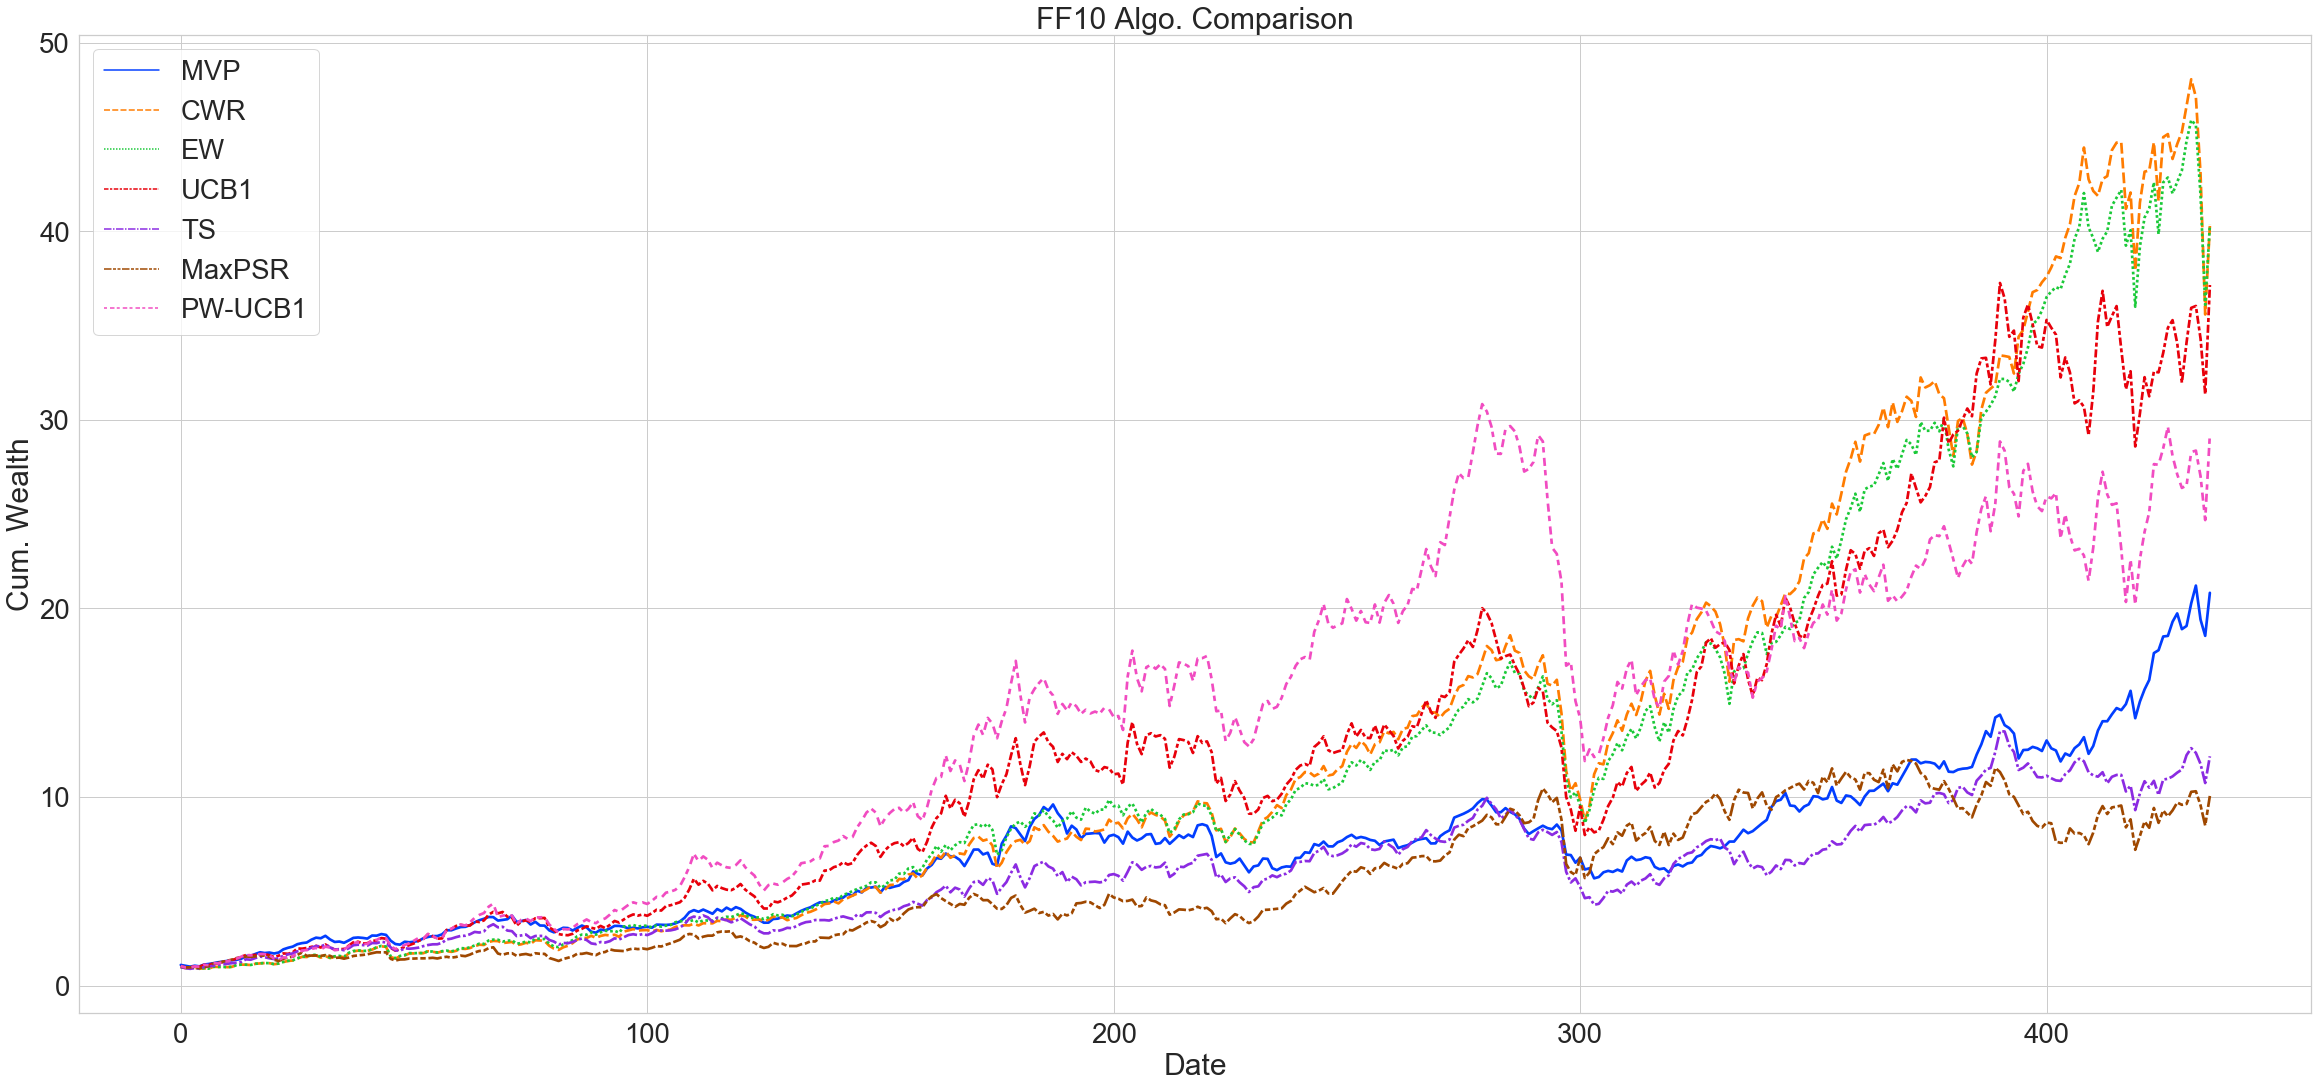

In [538]:
import seaborn as sns

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]
sns.set(style="whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(data=results_10, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(xlabel='Date', ylabel='Cum. Wealth', title="FF10 Algo. Comparison")

# 5-Port. Daily

In [428]:

data_30 = pd.read_csv('/Users/guneykan/Downloads/5_Industry_Portfolios_Daily.CSV', index_col=0)

data_30 = data_30[('197401' <= data_30.index.values.astype(str)) & (data_30.index.values.astype(str) <= '201912')]

data_30.index = pd.to_datetime(data_30.index, format="%Y%m%d")

date_30 = data_30.index.date

# The rate of return matrix, fill missing values with 100%
R_30 = data_30.values.T.astype(np.float)
#R_30[R_30 < -99]
R_30 = (R_30 + 100) / 100  # Gross Return

In [429]:
window_size = 120
orthogonal_bandit_portfolio_30 = BanditPortfolio(R_30)

In [430]:
orthogonal_bandit_portfolio_30.UCB(window_size = window_size)
ucb_30_wealth = np.cumprod(orthogonal_bandit_portfolio_30.reward)

In [431]:
orthogonal_bandit_portfolio_30.UCBPSR(window_size = window_size)
ucbpsr_30_wealth = np.cumprod(orthogonal_bandit_portfolio_30.reward)

In [432]:
orthogonal_bandit_portfolio_30.TS(window_size = window_size)
ts_30_wealth = np.cumprod(orthogonal_bandit_portfolio_30.reward)
mv_30_wealth = np.cumprod(orthogonal_bandit_portfolio_30.mv_reward)


In [433]:
orthogonal_bandit_portfolio_30.PSR(window_size = window_size)
psr_30_wealth = np.cumprod(orthogonal_bandit_portfolio_30.reward)

In [434]:
cw_30_wealth = np.cumprod(R_30[:,window_size:].mean(axis=0))
ew_30_wealth = np.mean(np.cumprod(R_30[:,window_size:], axis=1), axis=0)

In [435]:
date_30 = data_30.index.values[window_size:]
all_30_wealth = {"MVP": mv_30_wealth, "CWR": cw_30_wealth, "EW": ew_30_wealth, "UCB1": ucb_30_wealth, "TS": ts_30_wealth, "MaxPSR": psr_30_wealth, "PW-UCB1": ucbpsr_30_wealth}

results_30 = pd.DataFrame(all_30_wealth)
results_pct_30 = results_30.pct_change().dropna()
results_30.index = date_30
results_pct_30.index = date_30[1:]

In [467]:


years = pd.date_range(start="1974", end="2019", freq="y").year
years = [str(a) for a in years]

results_pct_30.index = pd.to_datetime(results_pct_30.index)

yearly_sharpes = {}

for col in results_pct_30.columns:
    col_ = {}
    for a in range(1, len(years)):
        col_[years[a]] = np.sqrt(252)*np.mean(results_pct_30.loc[years[a-1]:years[a], col])/np.std(results_pct_30.loc[years[a-1]:years[a], col])
    yearly_sharpes[col] = col_
    
yearly_sharpes = pd.DataFrame(yearly_sharpes)
yearly_sharpes.mean().sort_values(ascending=False)

TS         1.076174
MVP        1.054639
UCB1       1.033718
CWR        1.011394
EW         1.001131
PW-UCB1    0.999298
MaxPSR     0.941377
dtype: float64

[Text(0, 0.5, 'Cum. Wealth'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'FF30 Algo. Comparison')]

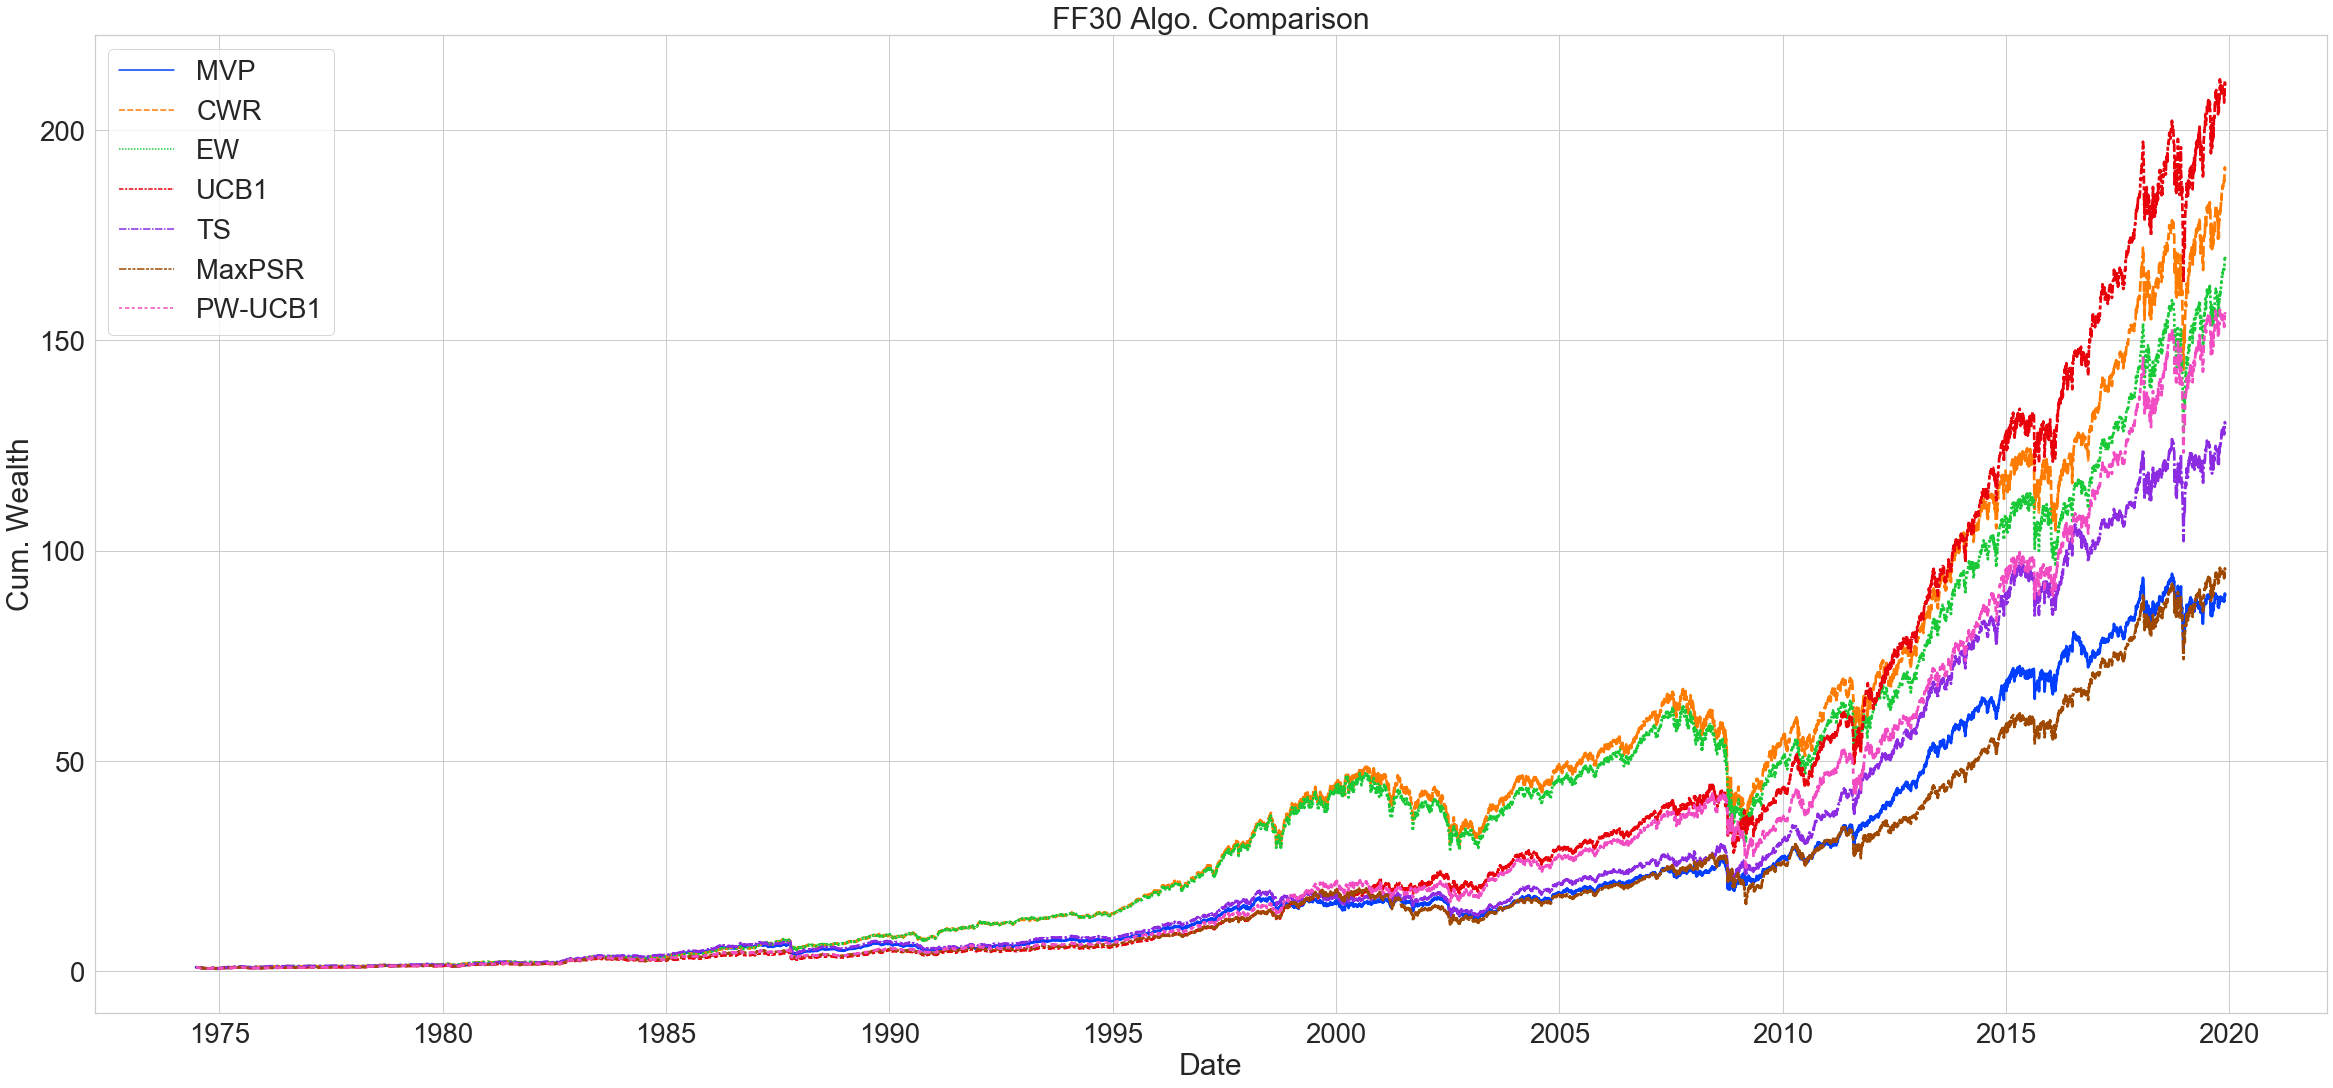

In [436]:
import seaborn as sns

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]
sns.set(style="whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(data=results_30, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(xlabel='Date', ylabel='Cum. Wealth', title="FF30 Algo. Comparison")